In [1]:
import os
import time
import re
from itertools import product

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

from dro.utils.flags import define_training_flags, define_eval_flags
from dro.utils.lfw import get_annotated_data_df, extract_person_from_filename,\
    extract_imagenum_from_filename, apply_thresh

Using TensorFlow backend.


In [2]:
os.chdir("/Users/jpgard/Documents/github/dro")
TEST_DIR = "/Users/jpgard/Documents/research/lfw/lfw-deepfunneled-sm-cropped"
ANNO_FP = "/Users/jpgard/Documents/research/lfw/lfw_attributes_cleaned.txt"
EMBEDDING_FP = "./embeddings/lfw_embeddings.csv"

# Read the embedding df and clean up strings.
embedding_df = pd.read_csv(EMBEDDING_FP)
# The first line below removes the leading "b'" artifact from the index string
# The file paths are redundant ("first_last/first_last_0001.jpg"), so second line drops the top-level directory
filenames = embedding_df.pop(embedding_df.columns[0])
filenames = filenames\
    .apply(lambda x: re.sub("^b'", '', x))\
    .apply(lambda x: x.split('/')[1])

embedding_df['person'] = filenames.apply(extract_person_from_filename)
embedding_df['imagenum_str'] = filenames.apply(extract_imagenum_from_filename)
embedding_df.set_index(['person', 'imagenum_str'], inplace=True)

# L2 normalize the embeddings
# tf_norm = tf.math.l2_normalize(embedding_df.values, axis=1).numpy()
embedding_df = embedding_df.apply(lambda x: x / np.linalg.norm(x, ord=2), axis=1)

# Fetch annotated data df, and convert paths to relative path (from FLAGS.test_dir)
anno_df = get_annotated_data_df(ANNO_FP, TEST_DIR)
anno_df['filename'] = anno_df['filename'].apply(lambda x: os.path.relpath(x, TEST_DIR))

In [3]:
def compute_d(df: pd.DataFrame):
    """Get the distance matrix from a pd.DataFrame of embeddings."""
    start = time.time()
    D = pdist(df.values, metric='sqeuclidean')
    D = squareform(D)
    end = time.time()
    print("Computed distance matrix of shape {} in {} secs".format(D.shape, end - start))
    return D

In [4]:
def construct_p_same(df):
    # Construct the matrix p_same. The i,j-th entry in p_same
    # is true if i and j are of the same identity; otherwise false.
    ids = np.array(embedding_df.index.get_level_values(0))
    p_same = [i == j for i,j in product(ids, ids)]
    n = len(embedding_df)
    p_same = np.array(p_same).reshape((n,n))
    # Sanity check: diagonal of p_same should all be true
    assert np.all(np.diagonal(p_same))
    # Sanity check: p_same is symmetric
    assert np.allclose(p_same, p_same.T)
    return p_same

In [5]:
def keep_upper_triangular_indices(ary):
    """Given an array of shape [n,2] where the
    columns represent (i,j) pairs, return the array
    filtered to only include entries where i > j.
    This op simultaneously de-duplicates the results
    (by filtering for i > j) and removes the set where i == j
    from true accepts (these have identical embeddings).
    """
    return ary[ary[:,0] > ary[:,1]]

In [6]:
def compute_val_and_far(D: np.ndarray, d:float, p_same: np.ndarray):
    """Compute the validation rate VAL(d) and the false accept
    rate FAR(d) for pairwise distance matrix D, threshold d,
    and identity set indicator matrix p_same."""
    assert D.dtype == np.float
    assert p_same.dtype == np.bool
    n = len(D)
    
    start = time.time()
    # Compute true accepts; this is equation (4) in FaceNet.
    # This computes indices where dist(i,j) <= d and (i,j) \in p_same.
    ta_d = np.argwhere(np.logical_and(D <= d, p_same == True))
    ta_d = keep_upper_triangular_indices(ta_d)

    # Compute false accepts; this is equation (5) in FaceNet
    fa_d = np.argwhere(np.logical_and(D <= d, p_same == False))
    fa_d = keep_upper_triangular_indices(fa_d)

    # Compute validation rate, equation (6)a
    n_p_same = (p_same.sum() - n) / float(2)
    # Equivalent, but slower:
    # n_p_same = len(keep_upper_triangular_indices(np.argwhere(p_same)))
    val_d = len(ta_d) / n_p_same

    # Compute false accept rate, equation (7)b
    n_p_diff = ((n) * (n-1) * 0.5) - n_p_same
    # Equivalent, but slower: 
    # n_p_diff = len(keep_upper_triangular_indices(np.argwhere(~p_same)))
    far_d = len(fa_d) / n_p_diff

    # Sanity check that n_p_same and n_p_diff have correct sum,
    # which is the number of elements in the upper-diagonal portion of
    # a square matrix.
    assert n_p_same + n_p_diff == n * (n-1) * 0.5

    end = time.time()
    print("VAL(d) @ d = {}: {}".format(d, val_d))
    print("FAR(d) @ d = {}: {}".format(d, far_d))
    print("Computed in {}sec".format(end - start))
    return val_d, far_d

In [7]:
def evaluate_embeddings(D, p_same, dmin=0.5, dmax=1.5, num=10):
    res = list()
    for dval in np.linspace(0.5, 1.5, num=num):
        val_d, far_d = compute_val_and_far(D, dval, p_same)
        res.append((val_d, far_d, dval))
    return np.array(res)

Computed distance matrix of shape (13194, 13194) in 15.72506308555603 secs


Text(0.5, 1.0, 'FaceNet Distances; LFW Dataset')

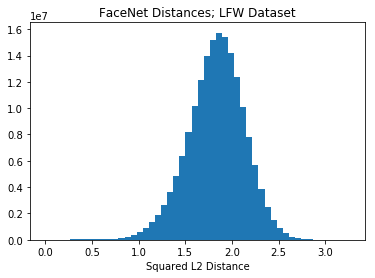

In [8]:
D = compute_d(embedding_df)
p_same = construct_p_same(embedding_df)

# Sanity check: D and p_same are both n x n matrices
assert D.shape == p_same.shape

# Sanity check: Show the distribution of pairwise distances
plt.hist(D.ravel(), bins=50)
plt.xlabel("Squared L2 Distance")
plt.title("FaceNet Distances; LFW Dataset")

In [9]:
data = evaluate_embeddings(D, p_same)

VAL(d) @ d = 0.5: 0.47674408986384764
FAR(d) @ d = 0.5: 4.2100444401645014e-05
Computed in 2.8664472103118896sec
VAL(d) @ d = 0.6111111111111112: 0.6683623670322763
FAR(d) @ d = 0.6111111111111112: 0.0001180287226191712
Computed in 2.344799041748047sec
VAL(d) @ d = 0.7222222222222222: 0.8009661356229424
FAR(d) @ d = 0.7222222222222222: 0.0003677624753300786
Computed in 2.367393970489502sec
VAL(d) @ d = 0.8333333333333333: 0.8798492894601883
FAR(d) @ d = 0.8333333333333333: 0.0011538102636205624
Computed in 2.210487127304077sec
VAL(d) @ d = 0.9444444444444444: 0.9224692706006915
FAR(d) @ d = 0.9444444444444444: 0.003327870760346124
Computed in 2.406141996383667sec
VAL(d) @ d = 1.0555555555555556: 0.9456465995003888
FAR(d) @ d = 1.0555555555555556: 0.008538036950755834
Computed in 2.3602030277252197sec
VAL(d) @ d = 1.1666666666666665: 0.9588358396611908
FAR(d) @ d = 1.1666666666666665: 0.019427027699523067
Computed in 3.2389800548553467sec
VAL(d) @ d = 1.2777777777777777: 0.9670744619253

Text(0, 0.5, 'Validation Rate (VAL)')

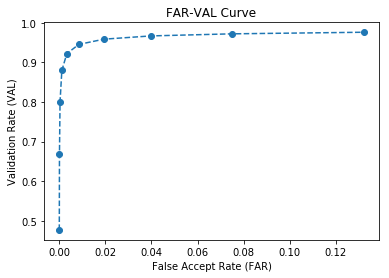

In [10]:
%matplotlib inline
plt.plot(data[:,1], data[:,0], marker='o', linestyle='dashed')
plt.title("FAR-VAL Curve")
plt.xlabel("False Accept Rate (FAR)")
plt.ylabel("Validation Rate (VAL)")

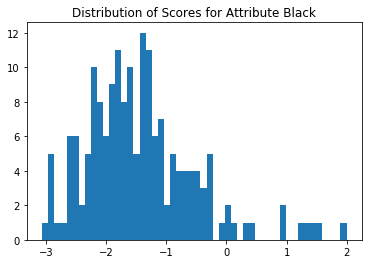

In [34]:
t = 0.  # Confidence threshold
SUBGROUPS = ["Black",]

for s in SUBGROUPS:
    plt.hist(anno_df.Black.values, bins=50)
    plt.title("Distribution of Scores for Attribute {}".format(s))
    anno_s = apply_thresh(anno_df, s, 0.3, use_abs=False)
    embedding_s = embedding_df.loc[anno_s.index]

In [38]:
anno_df.shape

(174, 76)